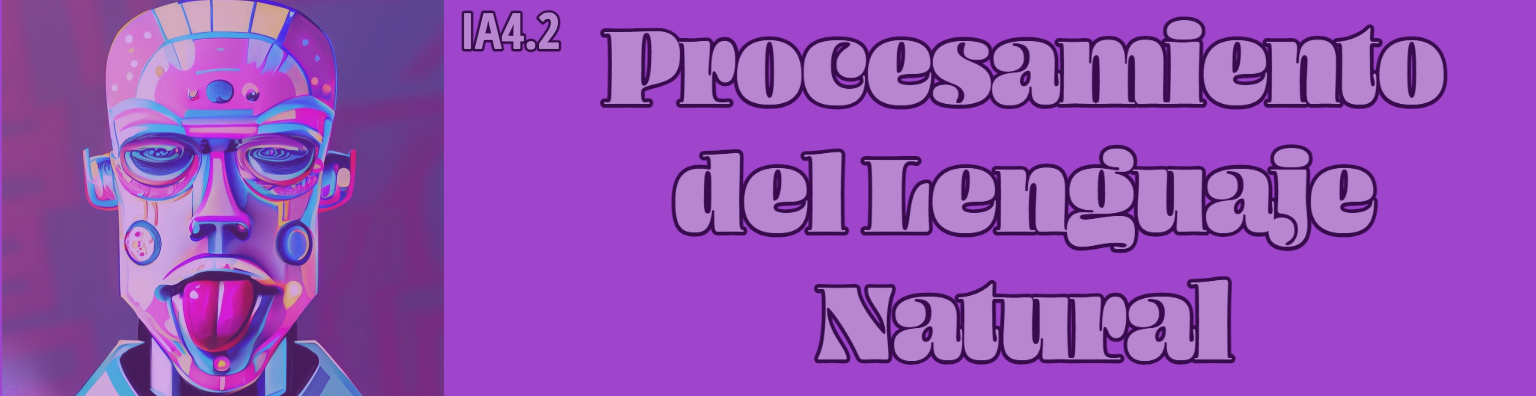

In [ ]:
!pip install PyPDF
!pip install chromadb
!pip install sentence-transformers
!pip install gradio
!pip install sparqlwrapper

In [2]:
!pip install langchain
!pip install langchain_openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.0/817.0 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.4/246.4 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.7/226.7 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 44.3 MB/s eta 0:00:00


In [3]:
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
from langchain.document_loaders import PyPDFLoader
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
import gradio as gr

# DOCUMENTO DE TEXTO

In [7]:
# Genero el modelo de Embeddings
embed_model =  HuggingFaceEmbeddings(model_name='sentence-transformers/paraphrase-multilingual-mpnet-base-v2')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/4.13k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
# Carga el pdf sobre reglas de fútbol
loader_futbol = PyPDFLoader("Futbol_ fifa.pdf")

# Divide el contenido del PDF en páginas
pages_futbol = loader_futbol.load_and_split()


In [9]:
# Concatena las páginas de pages_futbol
text_futbol = ''.join([page.page_content for page in pages_futbol])

In [10]:
# Crea un objeto para dividir el texto en fragmentos
text_splitter_basquet = CharacterTextSplitter(separator ="\n",chunk_size=800, chunk_overlap=10)

# Crea documentos a partir de los fragmentos de texto
documents = text_splitter_basquet.create_documents([text_futbol])

# Genero una base de datos
db = Chroma.from_documents(documents, embed_model)

# DATOS SQLITE

In [11]:
import sqlite3
con = sqlite3.connect("mundiales.db")

# Crea un cursor para ejecutar comandos SQL
cursor = con.cursor()

# Genera la tabla si no existe

cursor.execute("CREATE TABLE IF NOT EXISTS mundiales_stats (seleccion VARCHAR(100), titulos INTEGER,\
                finales INTEGER, semifinales INTEGER, cuartos INTEGER, octavos INTEGER, segundaronda INTEGER, \
                fasegrupos INTEGER, mejorresultado VARCHAR(255))")


# Abre el archivo "mundiales_stats.sql" que contiene instrucciones SQL
with open('mundiales_stats.sql', encoding="utf8") as f:
  sql_insterts=f.read()

# Divide las instrucciones SQL en una lista
sql_list = sql_insterts.split(";")
print(len(sql_list))

# Ejecuta cada instrucción SQL en la lista
for sql in sql_list:
    cursor.execute(sql)

# Confirma los cambios en la base de datos
con.commit()

# Cierra la conexión a la base de datos
con.close()


81


# GENERACIÓN DE CONTEXTOS SEGÚN LA FUENTE DE DATOS

In [12]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langchain.prompts import PromptTemplate
from google.colab import userdata
userdata.get('open_ia_api_key')
api_key = userdata.get('open_ia_api_key')
chat = ChatOpenAI(temperature=0, openai_api_key=api_key, model="gpt-3.5-turbo")


In [13]:


def search_in_sql(question: str):
    # Crea una plantilla de prompt para solicitar una consulta SQL
    prompt_template = PromptTemplate.from_template(
        """Sos un esperto en SQLLite. Tu tarea es crear un sql para SQLLite sintáticamente correcto listo para ejecutar \
    para contestar la pregunta dada a continuación y conociendo el esquema de la tabla. Sólo consultar las columnas \
    necesarias para responder la pregunta y alguna adicional que sirva para clarificar la respuesta.

    Prestá \
    atención y usá sólo los nombres de columna que puedes ver en la tabla que se indica a continuación. Tenés especial \
    cuidado de no consultar columnas que no existan. Prestá atención y usá la función CURRENT_DATE para obtener la fecha actual, si
    la pregunta tiene que ver con el "hoy".

    La salida sólo debe ser el sql listo para ejecutar.

    Esquema de tabla a consultar: ```mundiales_stats (seleccion VARCHAR(100), titulos INTEGER, finales INTEGER, semifinales INTEGER, cuartos INTEGER, \
    octavos INTEGER, segundaronda INTEGER, fasegrupos INTEGER, mejorresultado VARCHAR(255))```

    Pregunta: ```{question}```
    """)

    prompt_val = prompt_template.format(question=question)

    # Crea una lista de mensajes para interactuar con el modelo
    messages = [
        SystemMessage(content="Sos un esperto en SQLLite"),
        HumanMessage(content=prompt_val),
    ]

    response = chat.invoke(messages)
    sql_query = response.content
    sql_query = sql_query.replace("sql", "").replace("```", "")

    # Conecta a la base de datos
    con = sqlite3.connect("mundiales.db")
    cursor = con.cursor()

    #print(sql_query)
    try:
      # Ejecuta la consulta
      cursor.execute(sql_query)
      resultado = cursor.fetchall()

      # Obtiene los nombres de las columnas
      columnas = [descripcion[0] for descripcion in cursor.description]

      # Imprime los resultados en formato de texto
      contexto = ""
      for fila in resultado:
        for i in range(len(columnas)):
              contexto = contexto + str(columnas[i]) + ": " + str(fila[i]) + " "
        contexto =  contexto + "\n"
    except Exception as e:
       print(f"An error occurred: {e}")
       contexto = ""
    # Cierra la conexión
    con.close()

    # Procesa la pregunta para identificar palabras clave
    question_modf = ''.join(c for c in question if c.isalnum() or c.isspace())
    palabras_question = question_modf.split()
    sql_query_modif = ''.join(c for c in sql_query if c.isalnum() or c.isspace())
    #print(palabras_question)

    # Identifica palabras clave en la consulta SQL
    inf_extra_contexto = ""
    for i in palabras_question:
      if i in sql_query_modif:
        inf_extra_contexto += " " + i + " "

    return inf_extra_contexto + contexto



In [14]:
from SPARQLWrapper import SPARQLWrapper, JSON

# Configura el punto de acceso SPARQL de Wikidata
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

def get_wikidata_entity_name(wikidata_id):

    # URL del punto de acceso SPARQL de Wikidata
    url = 'https://query.wikidata.org/sparql'

    # Consulta SPARQL para obtener el nombre de la entidad
    query = f'''
    SELECT ?label WHERE
    {{
        SERVICE wikibase:label {{
            bd:serviceParam wikibase:language "en" .
            wd:{wikidata_id} rdfs:label ?label .
        }}
    }}
    '''
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()
    return {"label": data["results"]["bindings"][0]["label"]["value"]}



def get_wikidata_description(wikidata_id):
    url = 'https://query.wikidata.org/sparql'
    query = f'''
    SELECT ?description WHERE
    {{
        SERVICE wikibase:label {{
            bd:serviceParam wikibase:language "en" .
            wd:{wikidata_id} schema:description ?description .
        }}
    }}
    '''
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    data = sparql.query().convert()
    # Extrae la descripción de la entidad de los resultados
    return {"description": data["results"]["bindings"][0]["description"]["value"]}

def search_in_wikidata(question: str):
    # Crea una plantilla de prompt para solicitar una consulta SPARQL
    prompt_template = PromptTemplate.from_template(
        """Tu tarea es crear un consulta SPARQL para consultar datos de Wikidata \
        para contestar la pregunta dada a continuación. Es importante que la consulta sea sintáticamente correcto y esté lista para ejecutar.
        Armar la consulta para que el AUTO_LANGUAGE sea español.

        La salida sólo debe ser la consulta SPARQL lista para ejecutar sin ninguna explicación adicional. Siempre limita a máximo 10 registros

        Pregunta: ```{question}```"""
        )
    prompt_val = prompt_template.format(question=question)

    # Crea una lista de mensajes para interactuar con el modelo
    messages = [
        SystemMessage(content="Sos un asistente experto en SPARQL y Wikidata"),
        HumanMessage(content=prompt_val),
    ]

    response = chat.invoke(messages)

    wiki_query = response.content.replace('\n', '').replace("'","").replace("sparql", "").replace("```", "")
    print(wiki_query)

    # Realiza la consulta SPARQL a través de la URL del punto de acceso de Wikidata
    try:
      sparql.setQuery(wiki_query)
      sparql.setReturnFormat(JSON)
      results = sparql.query().convert()
      print(results)

      # Extrae los resultados de la consulta
      #head = results["head"]["vars"][0]

      context = ""

      for data in results["results"]["bindings"]:
          for head in  results["head"]["vars"]:
            if "WHERE" in head:
              continue
            valor = data[head]["value"]
            print("...data: "+ valor + " id? "+str(("http://www.wikidata.org/entity/" in valor)))
            if "http://www.wikidata.org/entity/" in valor:
              id = valor.replace("http://www.wikidata.org/entity/", "")
              try:
                descripcion =  str(get_wikidata_description(id)["description"])
              except:
                descripcion = ""
              context = context + head +": " + str(get_wikidata_entity_name(id)["label"]) + " - " + descripcion + "\n"
            else:
              context = context + head +": " + valor +  "\n"
    except Exception as e:
       print(f"An error occurred: {e}")
       context = ""

    return  context

In [15]:
def search_in_vector_store(question: str):
    # Realiza una búsqueda de similitud en la base de datos con la pregunta
    docs = db.similarity_search(question)
    # Inicializa una cadena para almacenar el contenido de las páginas relacionadas
    context_str = ''
    # Itera sobre los documentos encontrados en la búsqueda de similitud
    for node in docs:
        # Agrega el contenido de cada página al resultado final
        context_str += f"{node.page_content}\n"
    return context_str

# CLASIFICADOR

In [16]:
def clasificador(question: str):
     # Crea un objeto PromptTemplate con una plantilla predefinida para el clasificador.
    prompt_template = PromptTemplate.from_template(
        """Tu tarea es clasificar la pregunta que se te indica a continuación entre las siguientes tres categorias [reglamento, mundiales de fútbol, otros]

    La respuesta sólo debe ser una de las tres categorias sin otro texto.

    Pregunta: ```{question}```
    """)
    # Formatea la plantilla con la pregunta
    prompt_val = prompt_template.format(question=question)
    # Crea una lista de mensajes con un mensaje del sistema y un mensaje del usuario con la pregunta formateada.
    messages = [
        SystemMessage(content="Sos un experto en temas de deporte y ayudas a un asistente virtual a encontrar el contexto adecuado para contestar preguntas."),
        HumanMessage(content=prompt_val),
    ]
    # Llama al modelo de chat con los mensajes y obtiene la respuesta
    response = chat.invoke(messages)

    return response.content

In [17]:
def generar_respuesta(query: str, context: str):
  # Crea un objeto PromptTemplate con una plantilla predefinida que incluye el contexto y la pregunta.
  prompt_template = PromptTemplate.from_template(
    """La información de contexto es la siguiente:\n"
      "```{context_str}```"
      "\nUtilizando únicamente la información de contexto anterior y sin mencionarla en la respuesta, responde la siguiente pregunta. Si no podés contestar con información del contexto \
      respondé 'No tengo información suficiente.'.\n"
      "Pregunta: ```{query_str}```"""
  )
  # Formatea la plantilla con la pregunta y el contexto
  prompt_val = prompt_template.format(query_str=query, context_str=context)
  print(prompt_val)
  # Crea una lista de mensajes con un mensaje del sistema y un mensaje del usuario con la pregunta y el contexto formateados.
  messages = [
      SystemMessage(content="Eres un asistente útil que siempre responde con respuestas veraces, útiles y basadas en hechos."),
      HumanMessage(content=prompt_val),
  ]
  # Llama al modelo de chat con los mensajes y obtiene la respuesta
  response = chat.invoke(messages)
  return response.content

# CHATBOT

In [18]:
# Usa una interfaz de ChatInterface para el chat
def chat_response(query, history):
    # Usa la función clasificador para definir la categoría de la pregunta
    qtype = clasificador(query)
    print(qtype)
    context = ""
    if qtype == "reglamento":
      context = search_in_vector_store(query)
    elif qtype == "mundiales de fútbol":
      context = search_in_sql(query)
    else:
      context = search_in_wikidata(query)

    response = generar_respuesta(query, context)

    return  response

demo = gr.ChatInterface(fn = chat_response,examples=["¿Cuál es el equipo que ganó más mundiales y cuantas veces ganó?",
                                                     "Clubes de futbol",
                                                     "¿Cuánto mide el campo de juego de fútbol?",
                                                     "¿Cuántos mundiales ganaron Brasil y Argentina cada uno?",
                                                     "¿Cuál es el número de jugadores de los equipos de fútbol?",
                                                     "¿Cuántas semifinales de mundiales jugó Uruguay?",
                                                     "Jugadores de fútbol"] ,title = '⚽ CHATBOT DE FÚTBOL ⚽'
                                                     , chatbot=gr.Chatbot(value=[(None, "¡¡¡Hola!!! Soy un chatbot especializado en fútbol. Puedo ayudarte a resolver dudas sobre el reglamento, estadísticas de mundiales y otros temas relacionados.")]))

#demo.launch(debug=True)
demo.launch(debug=False)

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1523b66fc8cc700aff.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
